In [1]:
from IPython.core.display import display, HTML
display(HTML('<style>.container { width: 98% !important }</style>'))

In [2]:
from utilities import *

In [3]:
import joblib
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
from sklearn.preprocessing import normalize
import seaborn as sns
from sklearn.manifold import TSNE

sns.set()

In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

## Import Data

In [5]:
pin = read_pin('../Data/pin.csv')
test_pin = read_pin('../Data/testPin.csv')
ble = read_ble('../Data/ble.csv')

In [6]:
data_1 = read_data('../Data/rssi5.csv')
data_2 = read_data('../Data/rssi_2.csv')

All beacons: ['0117C55D14E4']
Selecting all
All beacons: ['0117C55D14E4']
Selecting all


In [7]:
test_1 = read_data('../Data/testRssi.csv')
test_2 = read_data('../Data/testRssi_2.csv')

All beacons: ['0117C55D14E4']
Selecting all
All beacons: ['0117C55D14E4']
Selecting all


In [8]:
data = pd.concat([data_1, data_2], axis=0)
test = pd.concat([test_2], axis=0)

In [9]:
test.shape

(18771, 19)

## Train Validation Split

In [10]:
train, validation = train_validation_split(data)

In [11]:
print(train.shape)
print(validation.shape)

(102033, 19)
(11337, 19)


In [12]:
def linear_impute(data):
    for s in scanners:
        dx = data['X'] - ble[s]['X']
        dy = data['Y'] - ble[s]['Y']
        d = np.sqrt(np.square(dy) + np.square(dx))
        reg = joblib.load('../Models/linear_distance_models_2/{}.joblib'.format(s))
        ss = pd.Series(reg.predict(d.values.reshape((-1, 1))))
        data[s].fillna(ss, inplace=True)

def impute(data):
    rolling_win = 30

    data = data.sort_values("time")
    data_rolled = data.groupby("location").rolling(rolling_win, min_periods=1).median().reset_index()
    data_imputed = data_rolled.set_index("location").groupby("location").ffill()
    data_imputed.reset_index(inplace=True)
    data_imputed["X"] = data_imputed["location"].apply(lambda x: pin[x]["X"] if x[0] == 'V' else test_pin[x]["X"])
    data_imputed["Y"] = data_imputed["location"].apply(lambda x: pin[x]["Y"] if x[0] == 'V' else test_pin[x]["Y"])
    linear_impute(data_imputed)
    return data_imputed

In [13]:
train_imputed = impute(train)
validation_imputed = impute(validation)
test_imputed = impute(test)

In [14]:
train_imputed[scanners] = normalize(train_imputed[scanners] + 100)
validation_imputed[scanners] = normalize(validation_imputed[scanners] + 100)
test_imputed[scanners] = normalize(test_imputed[scanners] + 100)

In [15]:
train_imputed

,location,level_1,C400A2E19293,CD4533FFC0E1,D2B6503554D7,DB8B36A69C56,DD697EA75B68,DF231643E227,E13B805C6CB0,E43355CA8B96,...,E8FD0B453DC4,E96AF2C858BA,EC72840D9AD3,F1307ECB3B90,F1EDAF28E08A,F69A86823B96,FB2EE01C18CE,FDAE5980F28C,X,Y
0,V1_10,30171,0.270859,0.233392,0.211301,0.353549,0.281666,0.193480,0.167370,0.284954,...,0.207280,0.113343,0.307202,0.356753,0.255005,0.218772,0.043828,0.278136,11.17660,5.29753
1,V1_10,30172,0.269998,0.232650,0.210630,0.352425,0.280771,0.192865,0.184881,0.284048,...,0.206622,0.112983,0.306226,0.355619,0.254194,0.218076,0.043688,0.277252,11.17660,5.29753
2,V1_10,30173,0.323051,0.228668,0.207025,0.346393,0.275966,0.189564,0.181716,0.279187,...,0.203085,0.111049,0.300985,0.349533,0.249844,0.214344,0.042941,0.272507,11.17660,5.29753
3,V1_10,30176,0.322614,0.228359,0.206745,0.345925,0.275592,0.189307,0.181471,0.278809,...,0.202811,0.110899,0.300577,0.352859,0.249506,0.214054,0.042883,0.272206,11.17660,5.29753
4,V1_10,30177,0.323185,0.228763,0.207111,0.346537,0.276080,0.189643,0.181792,0.279303,...,0.203170,0.111095,0.301110,0.348434,0.249948,0.214433,0.042959,0.272688,11.17660,5.29753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102028,V1_9,31037,0.274017,0.167765,0.212503,0.313162,0.167765,0.100659,0.223687,0.408229,...,0.201318,0.100659,0.307570,0.257240,0.318754,0.206911,0.067106,0.369084,8.17867,5.28213
102029,V1_9,31039,0.276470,0.169267,0.214405,0.304681,0.169267,0.101560,0.225690,0.411884,...,0.203121,0.101560,0.310324,0.259543,0.321608,0.180552,0.067707,0.372388,8.17867,5.28213
102030,V1_9,31040,0.276488,0.141065,0.214419,0.304701,0.169278,0.124137,0.225704,0.411910,...,0.203134,0.101567,0.315986,0.259560,0.321629,0.180563,0.067711,0.372412,8.17867,5.28213
102031,V1_9,31042,0.275843,0.140736,0.213919,0.303990,0.168883,0.123848,0.225178,0.416579,...,0.202660,0.101330,0.315249,0.258955,0.320879,0.180142,0.067553,0.371544,8.17867,5.28213


In [16]:
X_train, y_train = train_imputed[scanners].copy(), train_imputed['location'].copy()
X_validation, y_validation = validation_imputed[scanners].copy(), validation_imputed['location'].copy()
X_test, y_test = test_imputed[scanners].copy(), test_imputed['location'].copy()

train = train_imputed[scanners + ['location']].copy()
validation = validation_imputed[scanners + ['location']].copy()
test = test_imputed[scanners + ['location']].copy()

In [17]:
partial_train = train.groupby('location').tail(1000)[scanners + ['location']]
partial_test = test.groupby('location').tail(1000)[scanners + ['location']]

combined = pd.concat([partial_train, partial_test], axis=0)

In [18]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
tsne_results = tsne.fit_transform(combined[scanners])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 36771 samples in 0.019s...
[t-SNE] Computed neighbors for 36771 samples in 5.148s...
[t-SNE] Computed conditional probabilities for sample 1000 / 36771
[t-SNE] Computed conditional probabilities for sample 2000 / 36771
[t-SNE] Computed conditional probabilities for sample 3000 / 36771
[t-SNE] Computed conditional probabilities for sample 4000 / 36771
[t-SNE] Computed conditional probabilities for sample 5000 / 36771
[t-SNE] Computed conditional probabilities for sample 6000 / 36771
[t-SNE] Computed conditional probabilities for sample 7000 / 36771
[t-SNE] Computed conditional probabilities for sample 8000 / 36771
[t-SNE] Computed conditional probabilities for sample 9000 / 36771
[t-SNE] Computed conditional probabilities for sample 10000 / 36771
[t-SNE] Computed conditional probabilities for sample 11000 / 36771
[t-SNE] Computed conditional probabilities for sample 12000 / 36771
[t-SNE] Computed conditional probabilities for sa

In [19]:
combined['tsne-2d-1'] = tsne_results[:, 0]
combined['tsne-2d-2'] = tsne_results[:, 1]

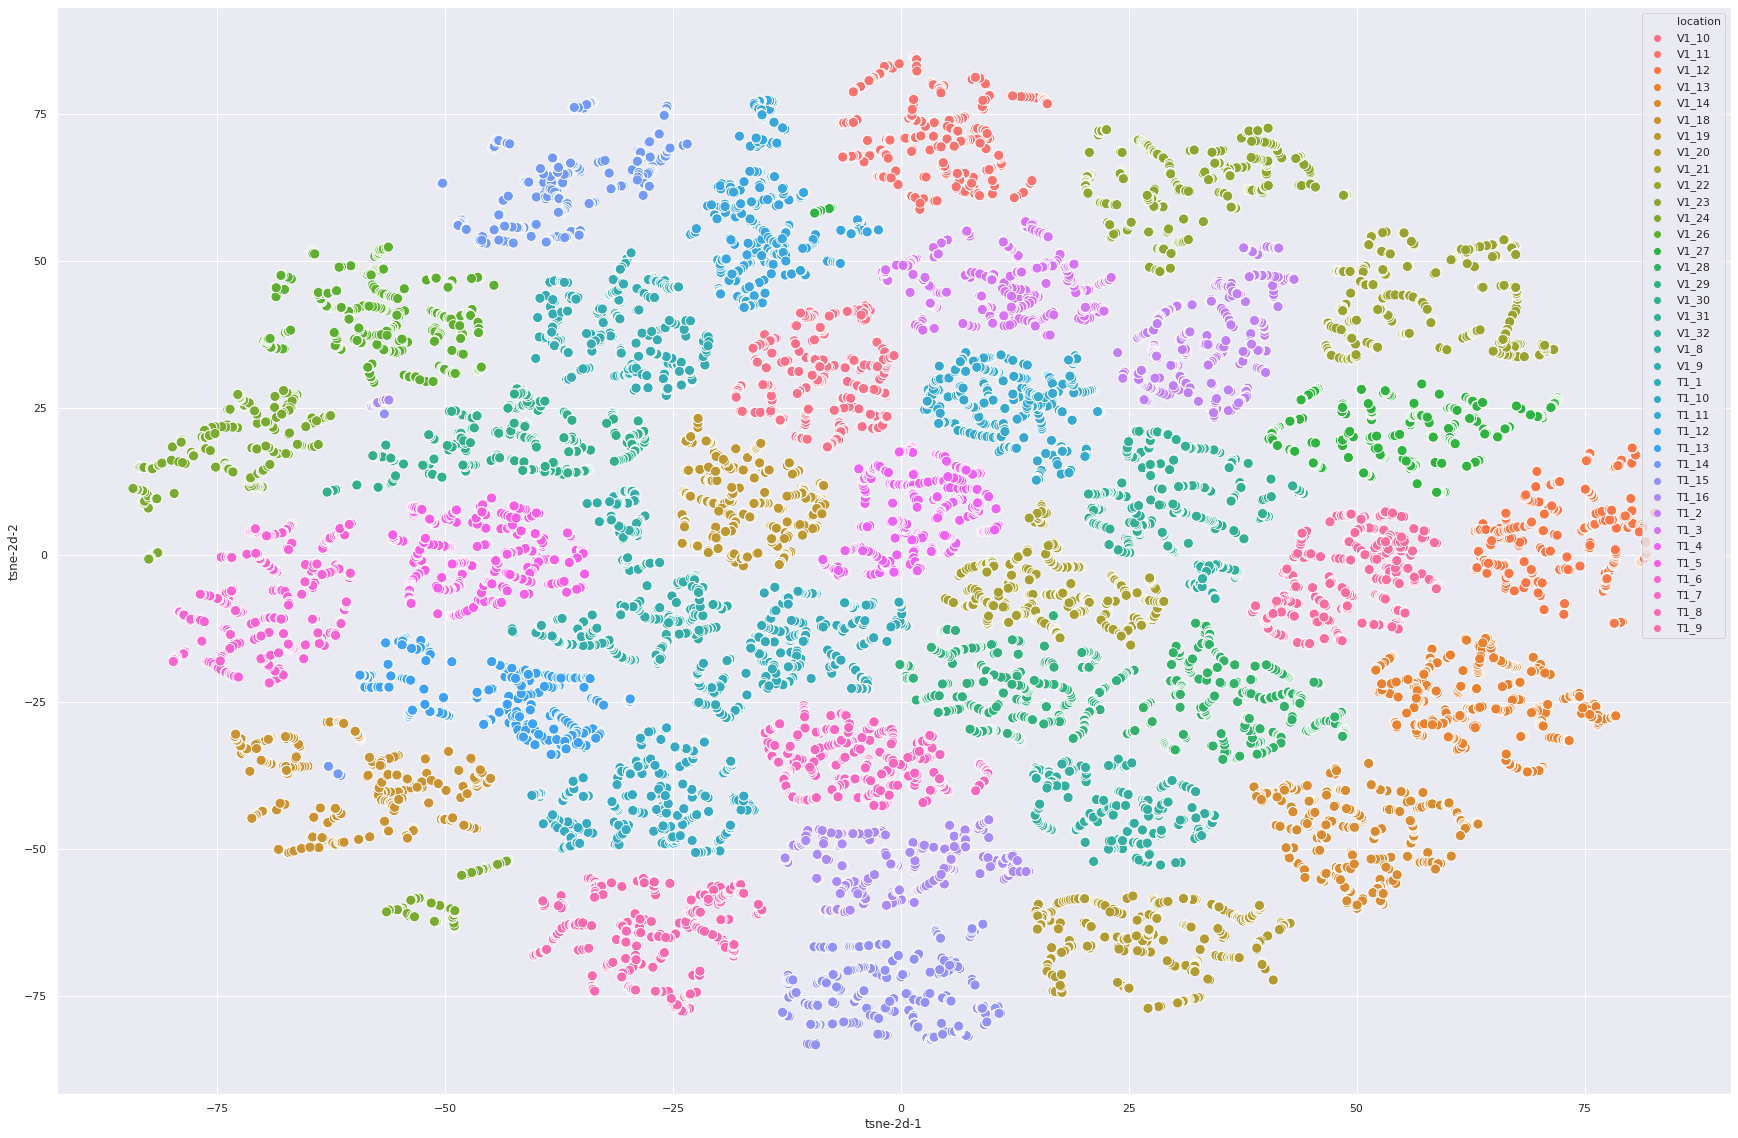

In [20]:
plt.figure(figsize=(30,20))
sns.scatterplot(
    x="tsne-2d-1", y="tsne-2d-2",
    hue="location",
#    palette=sns.color_palette("hls", 8),
    data=combined,
    legend="full",
#    alpha=0.3,
    s=100
)

In [21]:
interest = ['T1_2', 'T1_3', 'T1_4', 'T1_5', 'V1_22', 'V1_23', 'V1_30', 'V1_31']

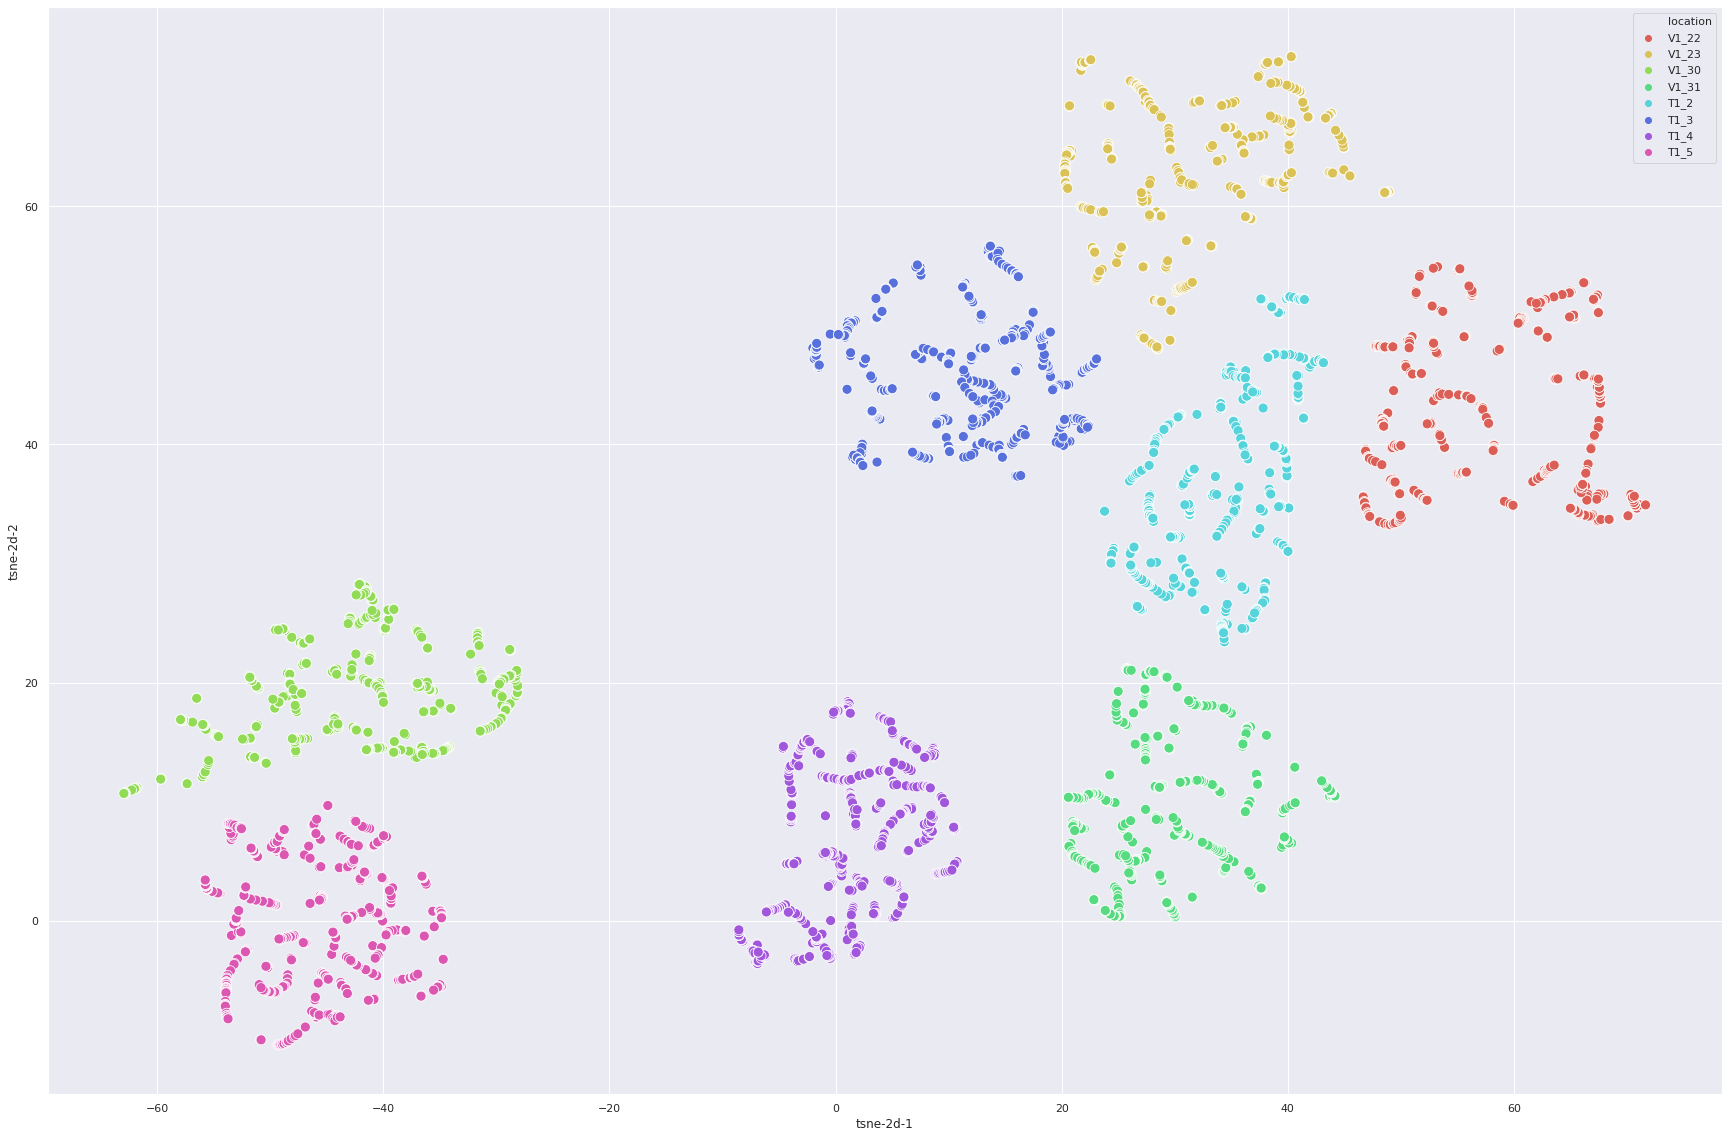

In [22]:
plt.figure(figsize=(30,20))
sns.scatterplot(
    x="tsne-2d-1", y="tsne-2d-2",
    hue="location",
    palette=sns.color_palette("hls", len(interest)),
    data=combined[combined['location'].isin(interest)],
    legend="full",
#    alpha=0.3,
    s=100
)